<a href="https://colab.research.google.com/github/gokul-pv/EVA6_Assignmets_Session5/blob/main/EVA6_Session_5_Code1_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Code1 - Setup**

Target

1. Get the set-up right with a light weight skeleton
2. Set Transforms
3. Set Data Loader
4. Set Basic Working Code
5. Set Basic Training  & Test Loop


Results
1.   Parameters - 7,864
2.   Best training accuracy- 98.47%
3.   Best test accuracy - 98.53%


Analysis
1. Good model!
2. No over-fitting, model is capable if pushed further




**Importing the necessary modules**

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import torchvision

**Data Transformations**

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])



# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like.It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [ ]:
'''Accessing a batch '''
sample_batch=next(iter(train_loader))
x1,y1=sample_batch

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


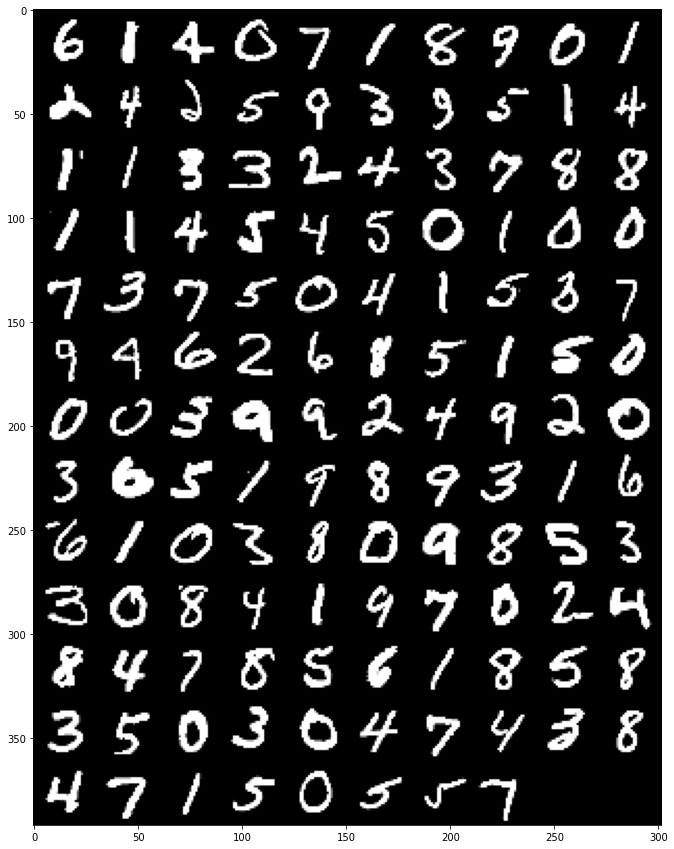

In [ ]:
'''Creating a grid of images'''
grid = torchvision.utils.make_grid(x1, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

**Defining the Model**

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=0, bias=False),       #Input: 28*28*1  Output: 26 * 26 * 8     RF = 3
            nn.ReLU(),

            nn.Conv2d(8, 10, 3, padding=0, bias=False),      #Input: 26*26*8  Output: 24 * 24 * 10    RF = 5 
            nn.ReLU(),

            nn.MaxPool2d(2, 2)                               #Input: 24*24*10  Output: 12 * 12 * 10   RF = 6       
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 12, 3, padding=0, bias=False),     #Input: 12*12*10  Output: 10 * 10 * 12   RF = 10 
            nn.ReLU(),

            nn.Conv2d(12, 14, 3, padding=0, bias=False),     #Input: 10*10*12    Output: 8 * 8 * 14   RF = 14
            nn.ReLU(),

            nn.Conv2d(14, 16, 3, padding=1, bias=False),     #Input: 8*8*16      Output: 8 * 8 * 16   RF = 18
            nn.ReLU(),

            nn.Conv2d(16, 16, 3, padding=0, bias=False),     #Input: 6*6*16      Output: 6 * 6 * 16   RF = 22
            nn.ReLU()          
        )
     

        self.avgpool = nn.AvgPool2d(6)                             # Global avergaing pooling is done to convert 2D data to 1D data Output: 1 * 1 * 16
        self.conv3   = nn.Conv2d(16, 10, 1, padding=0, bias=False) # a 1x1 convolution on 1D data is same as fully connected layer having 16 inputs and 10 outputs

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.avgpool(x)
        x = self.conv3(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

**Model summary**

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 10, 24, 24]             720
              ReLU-4           [-1, 10, 24, 24]               0
         MaxPool2d-5           [-1, 10, 12, 12]               0
            Conv2d-6           [-1, 12, 10, 10]           1,080
              ReLU-7           [-1, 12, 10, 10]               0
            Conv2d-8             [-1, 14, 8, 8]           1,512
              ReLU-9             [-1, 14, 8, 8]               0
           Conv2d-10             [-1, 16, 8, 8]           2,016
             ReLU-11             [-1, 16, 8, 8]               0
           Conv2d-12             [-1, 16, 6, 6]           2,304
             ReLU-13             [-1, 16, 6, 6]               0
        AvgPool2d-14             [

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


**Defining Train and Test Functions**

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

**Selecting the optmizer**

In [ ]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


**Training for 15 epoch**

In [ ]:
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)    

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=1.3668456077575684 Batch_id=468 Accuracy=14.88: 100%|██████████| 469/469 [00:10<00:00, 46.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.2677, Accuracy: 5412/10000 (54.12%)

EPOCH: 1


Loss=0.11022163182497025 Batch_id=468 Accuracy=82.30: 100%|██████████| 469/469 [00:10<00:00, 46.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3419, Accuracy: 8896/10000 (88.96%)

EPOCH: 2


Loss=0.29449746012687683 Batch_id=468 Accuracy=93.03: 100%|██████████| 469/469 [00:09<00:00, 46.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1754, Accuracy: 9434/10000 (94.34%)

EPOCH: 3


Loss=0.08025355637073517 Batch_id=468 Accuracy=95.32: 100%|██████████| 469/469 [00:09<00:00, 47.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1110, Accuracy: 9655/10000 (96.55%)

EPOCH: 4


Loss=0.08150198310613632 Batch_id=468 Accuracy=96.22: 100%|██████████| 469/469 [00:10<00:00, 46.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0902, Accuracy: 9714/10000 (97.14%)

EPOCH: 5


Loss=0.1307026892900467 Batch_id=468 Accuracy=96.79: 100%|██████████| 469/469 [00:09<00:00, 47.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0837, Accuracy: 9731/10000 (97.31%)

EPOCH: 6


Loss=0.045021090656518936 Batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:09<00:00, 47.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0763, Accuracy: 9760/10000 (97.60%)

EPOCH: 7


Loss=0.07262109220027924 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:10<00:00, 46.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0808, Accuracy: 9731/10000 (97.31%)

EPOCH: 8


Loss=0.08524352312088013 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:10<00:00, 46.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0654, Accuracy: 9798/10000 (97.98%)

EPOCH: 9


Loss=0.05648788809776306 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:10<00:00, 45.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0690, Accuracy: 9780/10000 (97.80%)

EPOCH: 10


Loss=0.02153634838759899 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:10<00:00, 45.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0539, Accuracy: 9838/10000 (98.38%)

EPOCH: 11


Loss=0.010522671975195408 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:10<00:00, 45.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0493, Accuracy: 9850/10000 (98.50%)

EPOCH: 12


Loss=0.018725385889410973 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:10<00:00, 45.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9853/10000 (98.53%)

EPOCH: 13


Loss=0.05369308218359947 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:10<00:00, 45.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9845/10000 (98.45%)

EPOCH: 14


Loss=0.042544882744550705 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:10<00:00, 44.63it/s]



Test set: Average loss: 0.0543, Accuracy: 9815/10000 (98.15%)



**Ploting the loss**

Text(0.5, 1.0, 'Test Accuracy')

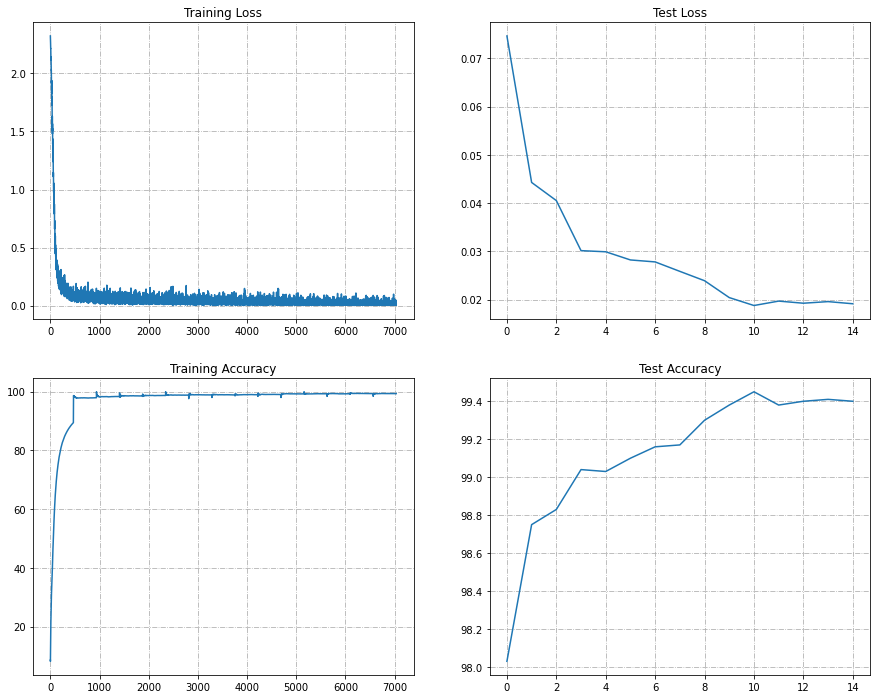

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,12))
axs[0, 0].plot(train_losses)
axs[0, 0].grid(linestyle='-.')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].grid(linestyle='-.')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].grid(linestyle='-.')
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].grid(linestyle='-.')
axs[1, 1].set_title("Test Accuracy")